<a href="https://colab.research.google.com/github/markkod/pc3-enzymes/blob/exploratory_da/exploratory_da_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#preinstalled version of pytorch has to be the same as the pre-compiled versions of the pytorch-geometric packages that we download later on.
#versions might change quickly, so if you get a strange error later on, check the torch version of Google colab later on as follows:

import torch
torch.__version__

'1.7.0+cu101'

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
# Script to generate variations of the kernels yourself
# https://ucloud.univie.ac.at/index.php/s/E3YKph0jkpbw8TN


# #Download the TUDataset Repository with
!git clone https://github.com/chrsmrrs/tudataset.git
# #move this script to tudataset/tud_benchmark

# #Install pytorch geometric: https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html
# #Here is the gpu cuda installation, for the cpu version replace cu102 with cpu
%pip --no-cache-dir install torch-scatter==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-cluster==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
%pip --no-cache-dir install torch-geometric

%pip --no-cache-dir install pybind11
!sudo apt-get install libeigen3-dev



fatal: destination path 'tudataset' already exists and is not an empty directory.
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 11.9MB 5.6MB/s 
  Found existing installation: torch-scatter 2.0.5
    Uninstalling torch-scatter-2.0.5:
      Successfully uninstalled torch-scatter-2.0.5
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 24.3MB 1.3MB/s 
  Found existing installation: torch-sparse 0.6.8
    Uninstalling torch-sparse-0.6.8:
      Successfully uninstalled torch-sparse-0.6.8
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 21.5MB 1.2MB/s 
  Found existing installation: torch-cluster 1.5.8
    Uninstalling torch-cluster-1.5.8:
      Successfully uninstalled torch-cluster-1.5.8
Looking in links: https://pytorch-geometric.com/whl/torch-1.7.0.html
     |████████████████████████████████| 6.4MB 5.3MB/s 
  

In [8]:
%cd ..
%cd /content/tudataset/tud_benchmark/kernel_baselines/
! ls
! g++ -I /usr/include/eigen3 -O3 -shared -std=c++11 -fPIC `python3 -m pybind11 --includes`  kernel_baselines.cpp src/*cpp -o ../kernel_baselines`python3-config --extension-suffix`
%cd ..

/
/content/tudataset/tud_benchmark/kernel_baselines
kernel_baselines.cpp  src
/content/tudataset/tud_benchmark


In [9]:
!ls -al /usr/local/cuda

lrwxrwxrwx 1 root root 9 Jan 20 17:22 /usr/local/cuda -> cuda-10.1


In [10]:
import os
import torch
import numpy as np
import kernel_baselines as kb
import auxiliarymethods
from auxiliarymethods import datasets as dp
from scipy.sparse import save_npz
from scipy.sparse import load_npz
from auxiliarymethods import auxiliary_methods as aux
from auxiliarymethods import kernel_evaluation as ke
from auxiliarymethods.reader import tud_to_networkx
from matplotlib import pyplot as plt
import networkx as nx
from collections import defaultdict
import pandas as pd
import seaborn as sns

In [11]:
def setup_directory(dir_name, verbose=False):
    """
    Setup directory in case it does not exist
    Parameters:
    -------------
    dir_name: str, path + name to directory
    verbose: bool, indicates whether directory creation should be printed or not.
    """
    if not os.path.exists(dir_name):
        try:
            os.makedirs(dir_name)
            if verbose:
                print("Created Directory: {}".format(dir_name))
        except Exception as e:
            raise RuntimeError(
                "Could not create directory: {}\n {}".format(dir_name, e))


In [8]:
use_edge_labels = False
for USE_LABELS in [True, False]:# Except IMDB-BINARY
    for dataset, use_labels in [["ENZYMES", USE_LABELS]]:
        if use_labels:
            base_path = os.path.join("kernels","node_labels")
        else:
            base_path = os.path.join("kernels","without_labels")
        setup_directory(base_path)
        print("Start processing data set ", dataset)
        # Download dataset.
        classes = dp.get_dataset(dataset)
        # *Weisfeihler-Lehman*
        print("Start computing Weisfeihler-Lehman gram matrix and vector representations")
        iterations = 9
        #0 taking just the nodelabels themselves into account; 
        #1 considers nearest-neighbours, 2 one layer deeper and so on
        for i in range(1, iterations):
            print("Start iteration ", i)
            #Gram Matrix for the Weisfeiler-Lehman subtree kernel
            gram_matrix_wl = kb.compute_wl_1_dense(dataset, i, use_labels, use_edge_labels)
            np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_wl{i}.csv"),
                    gram_matrix_wl,
                    delimiter=";")
            #Sparse Vectors for the Weisfeiler-Lehmann subtree kernel
            vectors_wl = kb.compute_wl_1_sparse(dataset, i, use_labels, use_edge_labels)
            save_npz(os.path.join(base_path,f"{dataset}_vectors_wl{i}.npz"),
                    vectors_wl, compressed=True)

        # *Graphlet kernel*
        print("Start computing Graphlet gram matrix")

        #Gram Matrix for the Graphlet kernel
        gram_matrix_graphlet= kb.compute_graphlet_dense(dataset, use_labels, use_edge_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_graphlet.csv"),
                gram_matrix_graphlet,
                delimiter=";")

        print("Start computing Graphlet vector representation")
        #Sparse Vectors for the Graphlet kernel
        vectors_graphlet = kb.compute_graphlet_sparse(dataset, use_labels, use_edge_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_graphlet.npz"),
                vectors_graphlet, compressed=True)


        print("Start computing Shortest path gram matrix")

        #Gram Matrix for the Shortest path kernel
        gram_matrix_shortestpath = kb.compute_shortestpath_dense(dataset, use_labels)
        np.savetxt(os.path.join(base_path,f"{dataset}_gram_matrix_shortestpath.csv"),
                gram_matrix_shortestpath,
                delimiter=";")

        print("Start computing Shortest path vector representation")

        #Sparse Vectors for the Shortest path kernel
        vectors_shortestpath = kb.compute_shortestpath_sparse(dataset, use_labels)
        save_npz(os.path.join(base_path,f"{dataset}_vectors_shortestpath.npz"),
                vectors_shortestpath, compressed=True)



Start processing data set  ENZYMES
Extracting /content/tudataset/tud_benchmark/datasets/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation
Start processing data set  ENZYMES
Start computing Weisfeihler-Lehman gram matrix and vector representations
Start iteration  1
Start iteration  2
Start iteration  3
Start iteration  4
Start iteration  5
Start iteration  6
Start iteration  7
Start iteration  8
Start computing Graphlet gram matrix
Start computing Graphlet vector representation
Start computing Shortest path gram matrix
Start computing Shortest path vector representation


In [ ]:
def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

In [ ]:
def visualize(G, color=None, figsize=(5,5)):
    plt.figure(figsize=figsize)
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, 
                     pos=nx.spring_layout(G, seed=42),
                     with_labels=True,
                     node_color=color,
                     cmap="Set2")
    plt.show()

In [ ]:
base_path = os.path.join("kernels", "node_labels")
ds_name = "ENZYMES"
classes = dp.get_dataset(ds_name)
G = tud_to_networkx(ds_name)
print(f"Number of graphs in data set is {len(G)}")
print(f"Number of classes {len(set(classes.tolist()))}")

Number of graphs in data set is 600
Number of classes 6


In [ ]:
def graph_list_properties(graphs, property):
  values = []
  for g in graphs:
    values.append(property(g))
  return values

In [ ]:
print(G[0].nodes[0])

{'labels': [1], 'attributes': [11.0, 15.887014, 37.78, -0.51, 1.701, 93.9, 4.0, 5.0, 2.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 6.0, 2.0]}


In [ ]:
print(G[0].nodes[0])
labels = set()
for g in G:
  for i in range(g.number_of_nodes()):
    labels.add(g.nodes[i]["labels"][0])
labels

{'labels': [1], 'attributes': [11.0, 15.887014, 37.78, -0.51, 1.701, 93.9, 4.0, 5.0, 2.0, 4.0, 4.0, 3.0, 3.0, 4.0, 4.0, 3.0, 6.0, 2.0]}


{1, 2, 3}

Num nodes:
6 [37, 23, 25, 24, 23, 24, 26, 88, 23, 32, 4, 14, 42, 41, 36, 55, 40, 38, 2, 35, 42, 41, 39, 42, 41, 40, 37, 23, 22, 34, 38, 38, 39, 8, 23, 42, 42, 100, 24, 24, 47, 45, 45, 45, 46, 44, 30, 32, 33, 9, 27, 39, 16, 18, 7, 18, 10, 21, 18, 10, 9, 39, 33, 29, 24, 25, 30, 38, 28, 28, 38, 40, 40, 42, 20, 19, 16, 17, 20, 18, 33, 23, 23, 35, 33, 39, 40, 38, 40, 38, 37, 36, 34, 34, 32, 18, 32, 34, 30, 5]

Cliques:
6 3026.1958762886597 [3316.0, 865.0, 1388.0, 1308.0, 975.0, 1169.0, 1071.0, 30099.0, 1295.0, 3599.0, 6.0, 229.0, 7371.0, 7034.0, 4579.0, 7157.0, 3189.0, 2861.0, 1.0, 3374.0, 5345.0, 5067.0, 4501.0, 5106.0, 4811.0, 4887.0, 3729.0, 805.0, 814.0, 3468.0, 3076.0, 3075.0, 3563.0, 48.0, 1115.0, 4619.0, 4649.0, inf, 1290.0, 956.0, 5645.0, 5490.0, 5512.0, 5512.0, 5744.0, 5112.0, 2849.0, 3125.0, 3304.0, 77.0, 1209.0, inf, 313.0, 470.0, 30.0, 450.0, 92.0, 641.0, 424.0, 92.0, 72.0, 5927.0, 3867.0, 2623.0, 1511.0, 1573.0, 2707.0, 3795.0, 1754.0, 2027.0, 2819.0, 6372.0, 4738.0, 5322.0, 81

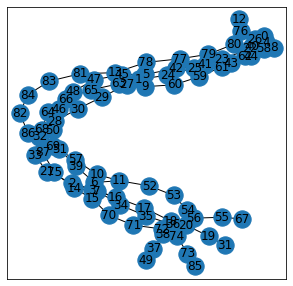

88

In [ ]:
graph_dict = defaultdict(list)
for i, g in enumerate(G):
  graph_dict[classes[i]].append(g)

for label_class in graph_dict:
  print("Num nodes:")
  num_nodes = graph_list_properties(graph_dict[label_class], lambda g: g.number_of_nodes())
  print(label_class, num_nodes)

  print()
  print("Cliques:")
  num_nodes = graph_list_properties(graph_dict[label_class], lambda g: nx.algorithms.wiener_index(g))
  print(label_class, np.average(np.array([n for n in num_nodes if str(n) != "inf"])), num_nodes)
  print()
  print()

visualize(graph_dict[6][7])
graph_dict[6][7].number_of_nodes()

In [ ]:
def find_keys_with_condition(data, cond):
    return list(filter(lambda x: cond in x, data.keys()))

def load_data():
  result = {}
  extensions = ['csv', 'npz']
  types = ['gram_matrix', 'vectors']
  algos = ['wl1', 'wl2', 'wl3', 'wl4', 'wl5', 'wl6', 'wl7', 'wl8', 'shortestpath', 'graphlet']
  base_name = '/content/tudataset/tud_benchmark/kernels/node_labels/ENZYMES_{0}_{1}.{2}'

  for t, e in zip(types, extensions):
    result[t] = {}
    for a in algos:
      algo_name = 'wl' if 'wl' in a else a

      if algo_name not in result[t].keys():
        result[t][algo_name] = []

      file_name = base_name.format(t, a, e)

      if e == 'csv':
        f = np.loadtxt(file_name, delimiter=';')
      else:
        f = load_npz(file_name)
      
      result[t][algo_name].append(f)
  return result

In [ ]:
data = load_data()
data

{'gram_matrix': {'graphlet': [array([[11177.,  6596.,  4333., ..., 11081., 13908., 10164.],
          [ 6596.,  4879.,  3005., ...,  4882.,  5786.,  3278.],
          [ 4333.,  3005.,  2132., ...,  2814.,  3236.,  1674.],
          ...,
          [11081.,  4882.,  2814., ..., 20397., 22060., 18291.],
          [13908.,  5786.,  3236., ..., 22060., 28850., 24883.],
          [10164.,  3278.,  1674., ..., 18291., 24883., 22359.]])],
  'shortestpath': [array([[ 73924.,  30546.,  35514., ...,  79166., 117398.,  96672.],
          [ 30546.,  15744.,  16882., ...,  36894.,  56388.,  46384.],
          [ 35514.,  16882.,  21316., ...,  33136.,  54940.,  44536.],
          ...,
          [ 79166.,  36894.,  33136., ..., 316796., 227164., 199264.],
          [117398.,  56388.,  54940., ..., 227164., 337252., 289668.],
          [ 96672.,  46384.,  44536., ..., 199264., 289668., 256200.]])],
  'wl': [array([[ 874.,  502.,  585., ...,  973.,  998.,  935.],
          [ 502.,  360.,  362., ...,  59

In [ ]:
def eval_kernel(kernel, classes, mode, n_reps=10, all_std=True):
  normalized = []
  print(f'Starting normalization of {len(kernel)} elements...')
  for array in kernel:
    if mode == 'LINEAR':
      normalized.append(aux.normalize_feature_vector(array))
    else:
      normalized.append(aux.normalize_gram_matrix(array))
  print(f'Normalization finished, starting {mode} SVM...')
  if mode == 'LINEAR':
    return ke.linear_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)
  return ke.kernel_svm_evaluation(normalized, classes, num_repetitions=n_reps, all_std=all_std)

def eval_all(data):
  classes = dp.get_dataset('ENZYMES')
  result = {}
  for data_type in data.keys():
    mode = 'LINEAR' if data_type == 'vectors' else 'KERNEL'
    result[data_type] = {}
    print('MODE:', mode)
    for kernel in data[data_type]:
      print(f'\nEvaluating {kernel} SVM...')
      result[data_type][kernel] = eval_kernel(data[data_type][kernel], classes, mode)
      print(f'{data_type}-{kernel} : {result[data_type][kernel]}')
  return result



In [ ]:
for array in data["gram_matrix"]["wl"]:
 normalized = [aux.normalize_gram_matrix(array)]
 print(ke.kernel_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True))

(39.783333333333346, 1.8901058171435792, 6.185354566321249)
(50.56666666666666, 1.4321700705960552, 6.844381312840158)
(51.13333333333334, 1.0588253449512368, 5.966945989737502)
(50.4, 1.2587471725666146, 6.092436111915969)
(50.06666666666667, 1.171893055416463, 6.280127387243033)
(49.43333333333334, 1.5584892970081288, 6.129255891034227)
(48.266666666666666, 0.7078920193865111, 5.436093368505651)
(47.650000000000006, 1.3772960627419406, 6.62526729020548)


In [ ]:
type(data["vectors"]["shortestpath"][0])

scipy.sparse.csc.csc_matrix

In [ ]:
val = data["vectors"]["wl"][2].T.dot(data["vectors"]["shortestpath"][0])
print(1)
normalized = [aux.normalize_feature_vector(val)]
print(2)
print(ke.linear_svm_evaluation(normalized, classes, num_repetitions=10, all_std=True))


In [ ]:
#eval_all(data)

#################node_labels#################


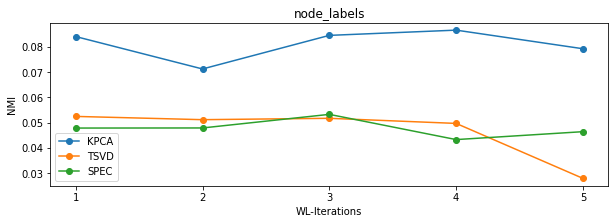

#################without_labels#################


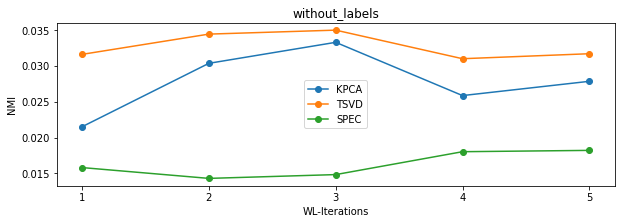

In [ ]:
algorithms = ["KPCA", "TSVD", "SPEC"]
for version in ["node_labels", "without_labels"]:
    print(f"#################{version}#################")
    all_nmi = {}

    for algorithm in algorithms:
        path_i = os.path.join('kernels', version, f'{algorithm}.csv')
        nmi_df = pd.read_csv(path_i, index_col=0)
        all_nmi[algorithm] = nmi_df['ENZYMES']

        max_nmi = nmi_df['ENZYMES'].max()
        max_nmi_id = nmi_df['ENZYMES'].idxmax()

    all_nmi_df = pd.DataFrame.from_dict(all_nmi)
    # print(all_nmi_df)

    fig, ax = plt.subplots(figsize=(10,3))
    ax.set_ylabel("NMI")
    ax.set_xlabel("WL-Iterations")
    ax.set_xticks([0,1,2,3,4,5,6])
    ax.set_xticklabels([1,2,3,4,5, 'graphlet', 'shortestpath'])
    ax.set_title(version)
    all_nmi_df.plot(marker="o", ax=ax)
    plt.show()


We start exploratory data analysis with analysing the NMI of different dimensionality reducing techniques. We compare the NMI for different WL iterations, for graph representations with and without node labels.

As we can see, the NMI on dataset with labels performs twice as good as on the dataset without labels: 8,5% vs 3,5%. From this we can make a conclusion that node labels contain about as much information as all other dimensions in the WL representation. This means that firstly we should definitely use representation with node labeling for clustering, secondly that clustering probably won't produce good results since the reduced data does not contain enough useful information.

In [9]:
rc = pd.read_csv('representation_comparison.csv')
rc_node_labels = rc[rc.Labels == True]
rc_without_labels = rc[rc.Labels == False]

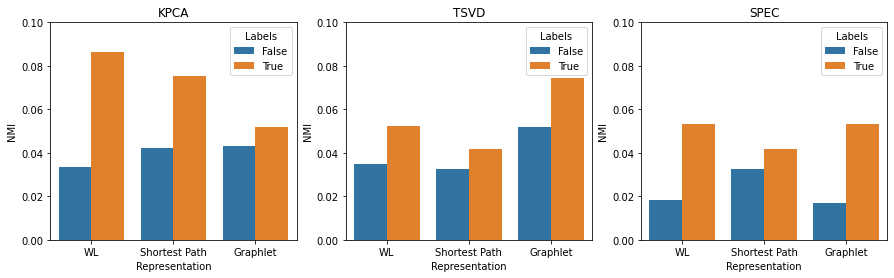

In [30]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

for (i, algorithm) in enumerate(rc.Algorithm.unique()):
  df = rc[rc.Algorithm==algorithm]
  axs[i].set_ylabel("NMI")
  axs[i].set_xlabel("Representation")
  axs[i].set_title(algorithm)
  axs[i].set_ylim([0,0.1])

  sns.barplot(x=df['Representation'], y=df["NMI"], data=df, hue='Labels', ax=axs[i])

plt.show()


Here we compare dimensionality reduction NMI not only for the WL represantation, but also shortest path and graphlet. We can clearly see that KPCA and WL representation are still the best options. Graphlet also shows pretty good results with TSVD. Interestingly, graphlet and shortest path perform better when node labels are not included, but the results are much worse than the ones produced by KPCA on WL with node labeling so we're going to concentrate on representations including node labeling.

In [13]:
reduced_kpca_dict = {}
reduced_tsvd_dict = {}

base_path = os.path.join("kernels", "node_labels")
dataset = "ENZYMES"
nmis_tsvd = {}
nmis_spec = {}
nmis_kpca = {}

classes = dp.get_dataset(dataset)
representations = ["wl2", "wl3", "wl4", "graphlet", "shortestpath"]

In [12]:
import os
import numpy as np
from auxiliarymethods import datasets as dp
from auxiliarymethods.reader import tud_to_networkx
import pandas as pd
from sklearn.decomposition import KernelPCA, TruncatedSVD
from matplotlib import pyplot as plt
from nrkmeans import NrKmeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score
import seaborn as sns
from scipy.sparse import load_npz
import auxiliarymethods.auxiliary_methods as aux
import networkx as nx
from sklearn.cluster import KMeans
from copy import deepcopy


def load_csv(path):
    return np.loadtxt(path, delimiter=";")

def load_sparse(path):
    return load_npz(path)

def select_from_list(l, indices):
    return [l[i] for i in indices]

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [26]:
ds_name = 'ENZYMES'

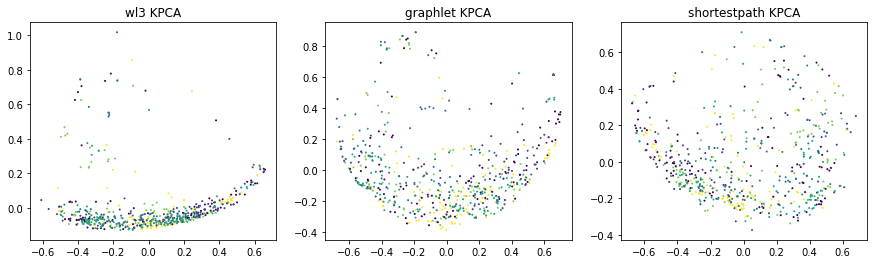

In [30]:
fig, axs = plt.subplots(1,3, figsize=(15,4))
representations = ["wl3", "graphlet", "shortestpath"]

for (i, representation) in enumerate(representations): 
    vec = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_{representation}.npz"))
    gram = load_csv(os.path.join(base_path,f"{ds_name}_gram_matrix_{representation}.csv"))
    gram = aux.normalize_gram_matrix(gram)

    kpca = KernelPCA(n_components=100, kernel="precomputed")
    reduced_kpca = kpca.fit_transform(gram)
    # fig, ax = plt.subplots(figsize=(5,5))
    axs[i].scatter(reduced_kpca[:,0], reduced_kpca[:,1], c=classes, s=1)
    axs[i].set_title(f'{representation} KPCA')

plt.show();

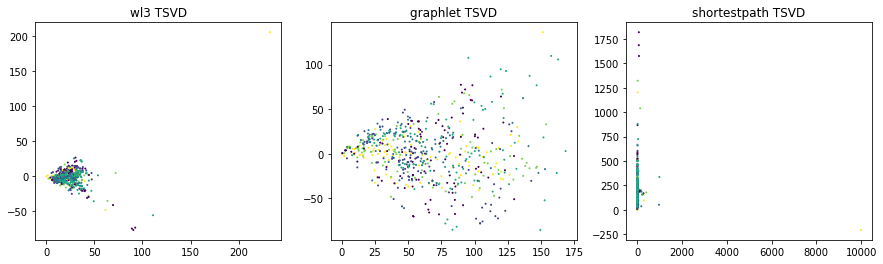

In [34]:
fig, axs = plt.subplots(1,3, figsize=(15,4))

for (i, representation) in enumerate(representations): 
    vec = load_sparse(os.path.join(base_path,f"{ds_name}_vectors_{representation}.npz"))
    tsvd = TruncatedSVD(n_components=100)
    reduced_tsvd = tsvd.fit_transform(vec)

    # fig, ax = plt.subplots(figsize=(5,5))
    axs[i].scatter(reduced_tsvd[:,0], reduced_tsvd[:,1], c=classes, s=1)
    axs[i].set_title("Representation: " + representation)
    axs[i].set_title(f'{representation} TSVD')

plt.show();

Here we plot the data with dimensionalities reduced by KPCA and TSVD. As we can see, TSVD performs best for graphlet, because for other representation it just crumbles the data in one point and the information gets lost. KPCA representation is more clear, but we see that points belonging to the same EC classes don't actually belong to the same clusters. 